In [118]:
from astroML.datasets import generate_mu_z
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import NadarayaWatson
from astroML.linear_model import BasisFunctionRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
#from tqdm import tqdm

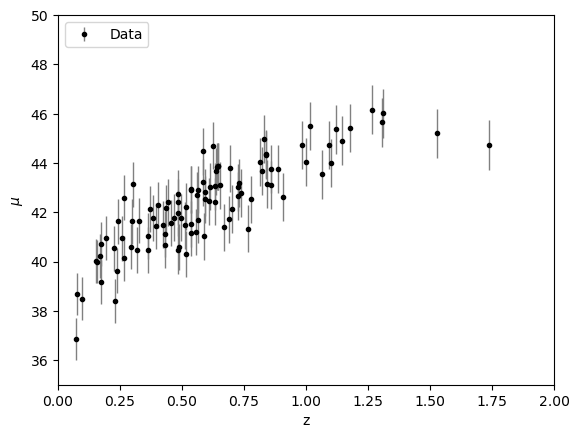

In [153]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='upper left')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

In [5]:
z_grid = np.linspace(0.05, 2., 1000)

## Linear Regression

In [6]:
lin_reg = LinearRegression()
lin_reg.fit(z_sample[:, np.newaxis], mu_sample, sample_weight=1.0/dmu**2)

theta0 = lin_reg.intercept_
theta1 = lin_reg.coef_

print(theta0, theta1[0])

39.483846022957295 4.7643886477497945


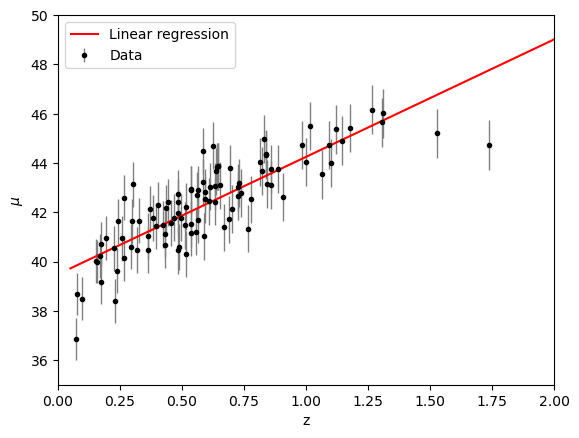

In [34]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')
plt.plot(z_grid, lin_reg.predict(z_grid[:, np.newaxis]), color = 'red', label='Linear regression')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='upper left')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

## Polynomial Regression

In [174]:
def poly(degree):
    model = PolynomialRegression(degree)
    model.fit(z_sample[:,np.newaxis], mu_sample, dmu)
    return model.predict(z_grid[:,np.newaxis])

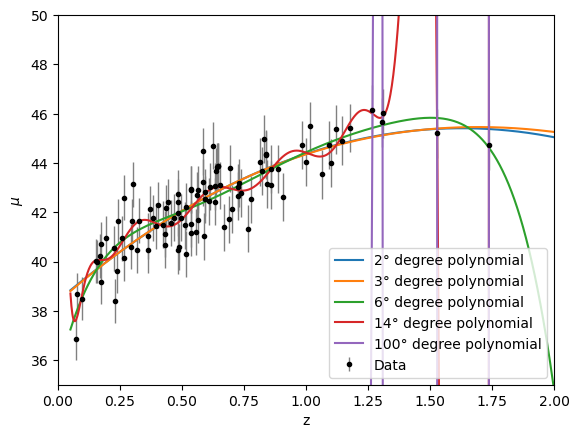

In [35]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')
plt.plot(z_grid, poly(2), label='2° degree polynomial')
plt.plot(z_grid, poly(3), label='3° degree polynomial')
plt.plot(z_grid, poly(6), label='6° degree polynomial')
plt.plot(z_grid, poly(14), label='14° degree polynomial')
plt.plot(z_grid, poly(100), label='100° degree polynomial')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

## Basis function regression

In [60]:
def basis(sigma):
    basis = BasisFunctionRegression('gaussian', mu=np.linspace(min(z_sample), max(z_sample), 10)[:, np.newaxis], sigma=sigma)
    basis.fit(z_sample[:,np.newaxis], mu_sample, dmu)
    return basis.predict(z_grid[:, np.newaxis])

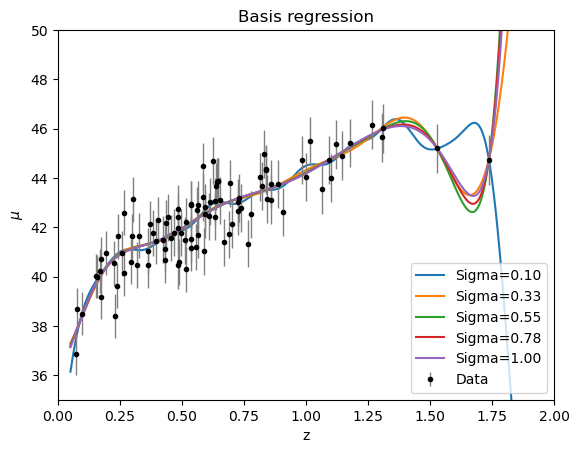

In [71]:
sigma = np.linspace(0.1, 1, 5)
for s in sigma:
    plt.plot(z_grid, basis(s), label='Sigma=%0.2f' %s)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.title('Basis regression')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

## Kernerl regression

In [180]:
def kernel(h):
    kernel = NadarayaWatson(kernel='gaussian', h=h)
    kernel.fit(z_sample[:,np.newaxis], mu_sample, dmu)
    return kernel.predict(z_grid[:, np.newaxis])

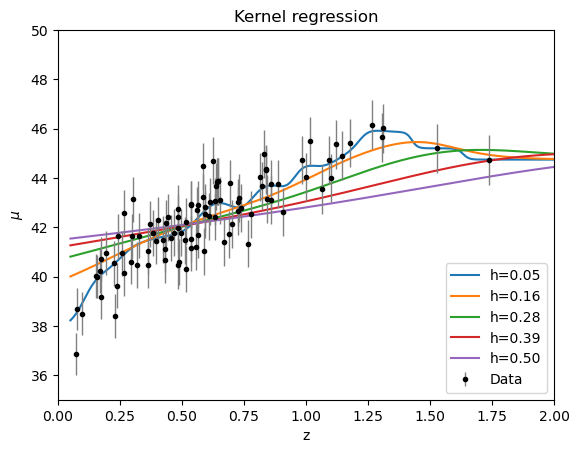

In [116]:
hs = np.linspace(0.05, 0.5, 5)
for h in hs:
    plt.plot(z_grid, kernel(h), label='h=%0.2f' %h)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.title('Kernel regression')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

## Cross Validation (RIVEDI DA QUI IN POI)

#### Polynomial regression

In [175]:
degreeerange = np.arange(1, 11)
k = 10
grid_deg = GridSearchCV(PolynomialRegression(), {'degree': degreerange}, cv= k, scoring = 'neg_root_mean_squared_error', return_train_score = True)
grid_deg.fit(z_sample[:,np.newaxis], mu_sample, y_error = dmu)
best_degree = grid_deg.best_params_['degree']
print('The best degree for the polynomial regression is', best_degree)

The best degree for the polynomial regression is 2


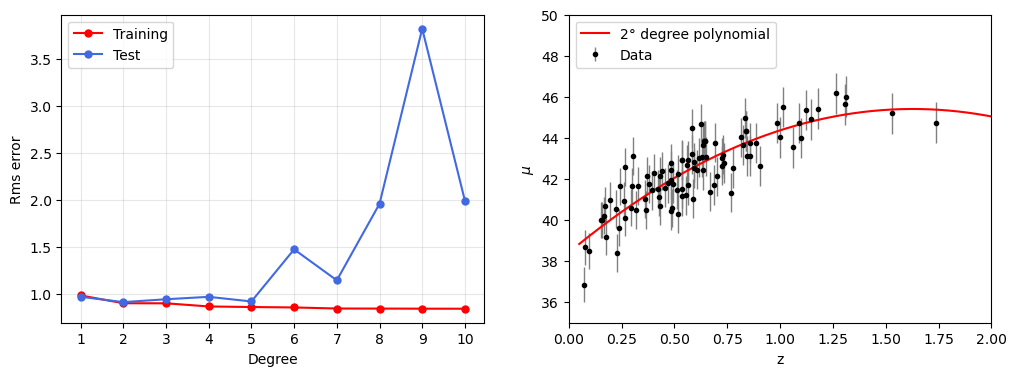

In [176]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(degreerange, -grid_deg.cv_results_['mean_train_score'], color = 'red', label = 'Training', marker = 'o', ms = 5)
axs[0].plot(degreerange, -grid_deg.cv_results_['mean_test_score'], color = 'royalblue', label = 'Test', marker = 'o', ms = 5)
axs[0].set_xlabel('Degree')
axs[0].set_ylabel('Rms error')
axs[0].set_xticks(degreerange)
axs[0].grid(alpha=0.3)
axs[0].legend()

axs[1].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')
axs[1].plot(z_grid, poly(best_degree), color = 'red', label='%i° degree polynomial' %best_degree)
axs[1].set_xlabel("z")
axs[1].set_ylabel("$\mu$")
axs[1].legend(loc='upper left')
axs[1].set_xlim(0,2)
axs[1].set_ylim(35,50)
plt.show()

#### Kernel regression

In [181]:
hrange = np.linspace(0.01, 0.5, 50)
k = 10
grid_h = GridSearchCV(NadarayaWatson(), {'h': hrange}, cv= k, scoring = 'neg_root_mean_squared_error', return_train_score = True)
grid_h.fit(z_sample[:,np.newaxis], mu_sample)#, y_error = dmu)
best_h = grid_h.best_params_['h']
print('The best degree for the polynomial regression is', best_h)

The best degree for the polynomial regression is 0.04


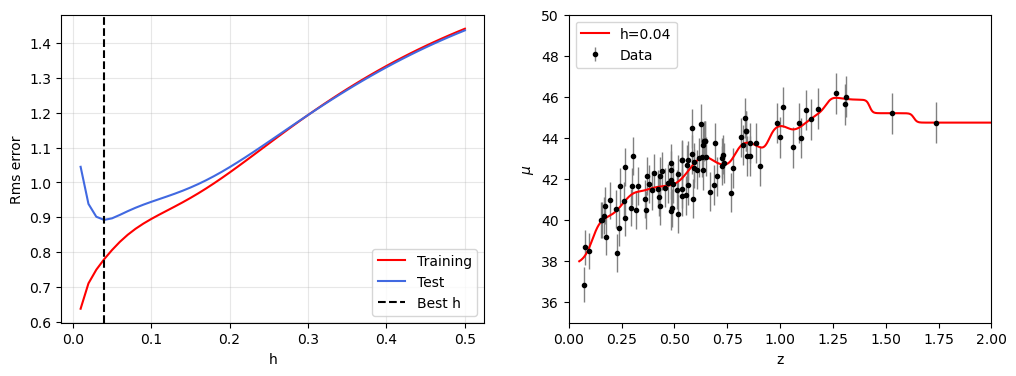

In [182]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(hrange, -grid_h.cv_results_['mean_train_score'], color = 'red', label = 'Training')#, marker = 'o', ms = 5)
axs[0].plot(hrange, -grid_h.cv_results_['mean_test_score'], color = 'royalblue', label = 'Test')#, marker = 'o', ms = 5)
axs[0].set_xlabel('h')
axs[0].set_ylabel('Rms error')
axs[0].axvline(best_h, color = 'black', ls = '--', label = 'Best h')
axs[0].grid(alpha=0.3)
axs[0].legend()

axs[1].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')
axs[1].plot(z_grid, kernel(best_h), color = 'red', label='h=%0.2f' %best_h)
axs[1].set_xlabel("z")
axs[1].set_ylabel("$\mu$")
axs[1].legend(loc='upper left')
axs[1].set_xlim(0,2)
axs[1].set_ylim(35,50)
plt.show()

## Learning curves (GUARDA SUL SITO DI SKLEARN COSA FA LA FUNZIONE)

#### Polynomial regression

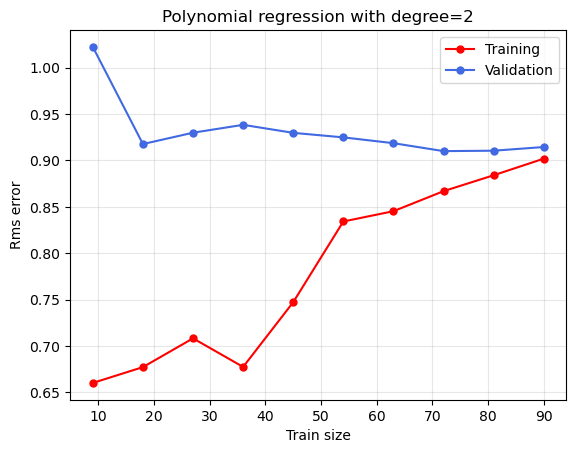

In [183]:
k = 10
train_size, train_scores, validation_scores = learning_curve(PolynomialRegression(best_degree), z_sample[:, np.newaxis], mu_sample, scoring='neg_root_mean_squared_error', train_sizes=np.linspace(0.1, 1, 10), cv=k)

plt.plot(train_size, -np.mean(train_scores, axis=1), color = 'red', label = 'Training', marker = 'o', ms = 5)
plt.plot(train_size, -np.mean(validation_scores, axis=1), color = 'royalblue', label = 'Validation', marker = 'o', ms = 5)
plt.title('Polynomial regression with degree=%i' %best_degree)
plt.xlabel('Train size')
plt.ylabel('Rms error')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [184]:
z_train_70, z_cross_70, mudmu_train_70, mudmu_cross_70 = train_test_split(z_sample[:,np.newaxis], np.array([mu_sample,dmu]).T, test_size=0.3, random_state=42)
mu_train_70, dmu_train_70 = mudmu_train_70.T
mu_cross_70, dmu_cross_70 = mudmu_cross_70.T

z_train_40, z_cross_40, mudmu_train_40, mudmu_cross_40 = train_test_split(z_sample[:,np.newaxis], np.array([mu_sample,dmu]).T, test_size=0.6, random_state=42)
mu_train_40, dmu_train_40 = mudmu_train_40.T
mu_cross_40, dmu_cross_40 = mudmu_cross_40.T

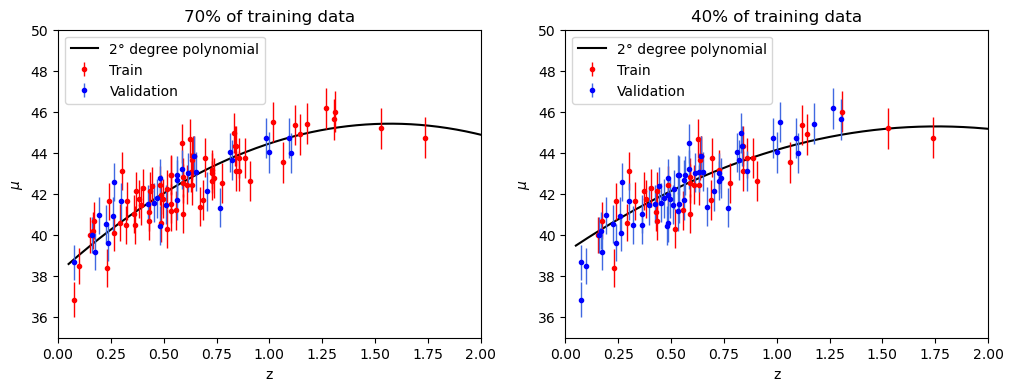

In [185]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

poli = PolynomialRegression(best_degree)
poli.fit(z_train_70, mu_train_70, dmu_train_70)
mu_pred =  poli.predict(z_grid[:,np.newaxis])

axs[0].plot(z_grid, mu_pred, color = 'black', label='%i° degree polynomial' %best_degree)
axs[0].errorbar(z_train_70, mu_train_70, dmu_train_70, fmt='.r', ecolor='red', lw=1, label='Train')
axs[0].errorbar(z_cross_70, mu_cross_70, dmu_cross_70, fmt='.b', ecolor='royalblue', lw=1, label='Validation')
axs[0].set_title('70% of training data')
axs[0].set_xlabel("z")
axs[0].set_ylabel("$\mu$")
axs[0].legend(loc='upper left')
axs[0].set_xlim(0,2)
axs[0].set_ylim(35,50)


poli.fit(z_train_40, mu_train_40, dmu_train_40)
mu_pred =  poli.predict(z_grid[:,np.newaxis])

axs[1].plot(z_grid, mu_pred, color = 'black', label='%i° degree polynomial' %best_degree)
axs[1].errorbar(z_train_40, mu_train_40, dmu_train_40, fmt='.r', ecolor='red', lw=1, label='Train')
axs[1].errorbar(z_cross_40, mu_cross_40, dmu_cross_40, fmt='.b', ecolor='royalblue', lw=1, label='Validation')
axs[1].set_title('40% of training data')
axs[1].set_xlabel("z")
axs[1].set_ylabel("$\mu$")
axs[1].legend(loc='upper left')
axs[1].set_xlim(0,2)
axs[1].set_ylim(35,50)

plt.show()

#### Kernel regression

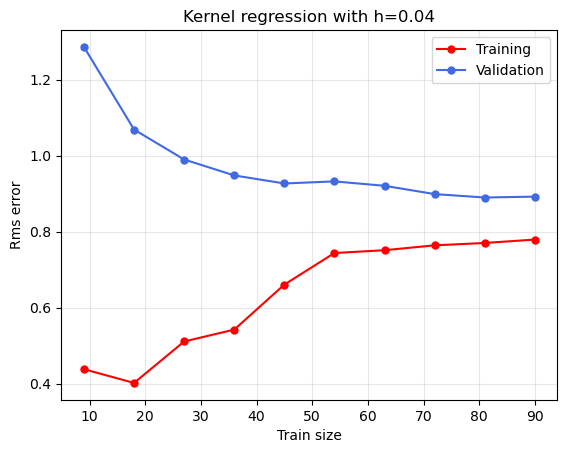

In [186]:
k = 10
train_size, train_scores, validation_scores = learning_curve(NadarayaWatson(kernel='gaussian', h=best_h), z_sample[:, np.newaxis], mu_sample, scoring='neg_root_mean_squared_error', train_sizes=np.linspace(0.1, 1, 10), cv=k)

plt.plot(train_size, -np.mean(train_scores, axis=1), color = 'red', label = 'Training', marker = 'o', ms = 5)
plt.plot(train_size, -np.mean(validation_scores, axis=1), color = 'royalblue', label = 'Validation', marker = 'o', ms = 5)
plt.title('Kernel regression with h=%0.2f' %best_h)
plt.xlabel('Train size')
plt.ylabel('Rms error')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

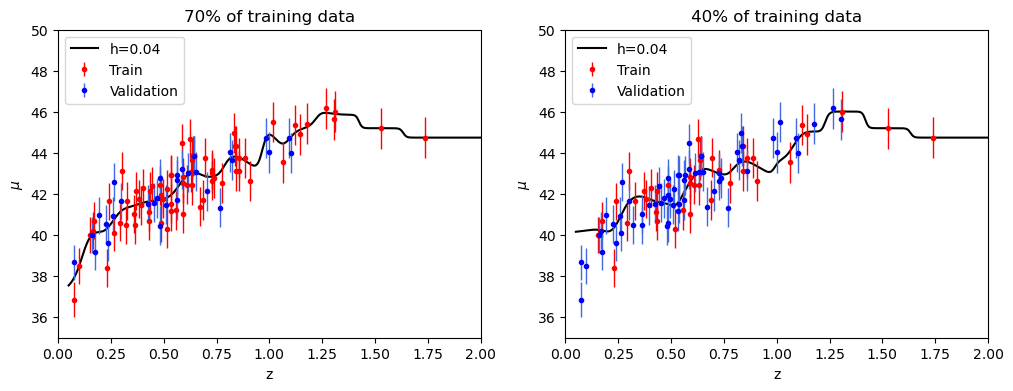

In [187]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

kern = NadarayaWatson(kernel='gaussian', h=best_h)
kern.fit(z_train_70, mu_train_70, dmu_train_70)
mu_pred =  kern.predict(z_grid[:,np.newaxis])

axs[0].plot(z_grid, mu_pred, color = 'black', label='h=%0.2f' %best_h)
axs[0].errorbar(z_train_70, mu_train_70, dmu_train_70, fmt='.r', ecolor='red', lw=1, label='Train')
axs[0].errorbar(z_cross_70, mu_cross_70, dmu_cross_70, fmt='.b', ecolor='royalblue', lw=1, label='Validation')
axs[0].set_title('70% of training data')
axs[0].set_xlabel("z")
axs[0].set_ylabel("$\mu$")
axs[0].legend(loc='upper left')
axs[0].set_xlim(0,2)
axs[0].set_ylim(35,50)


kern.fit(z_train_40, mu_train_40, dmu_train_40)
mu_pred =  kern.predict(z_grid[:,np.newaxis])

axs[1].plot(z_grid, mu_pred, color = 'black', label='h=%0.2f' %best_h)
axs[1].errorbar(z_train_40, mu_train_40, dmu_train_40, fmt='.r', ecolor='red', lw=1, label='Train')
axs[1].errorbar(z_cross_40, mu_cross_40, dmu_cross_40, fmt='.b', ecolor='royalblue', lw=1, label='Validation')
axs[1].set_title('40% of training data')
axs[1].set_xlabel("z")
axs[1].set_ylabel("$\mu$")
axs[1].legend(loc='upper left')
axs[1].set_xlim(0,2)
axs[1].set_ylim(35,50)

plt.show()

In [56]:
z_train, z_cross, mudmu_train, mudmu_cross = train_test_split(z_sample[:,np.newaxis], np.array([mu_sample,dmu]).T, test_size=0.3, random_state=42)
mu_train, dmu_train = mudmu_train.T
mu_cross, dmu_cross = mudmu_cross.T

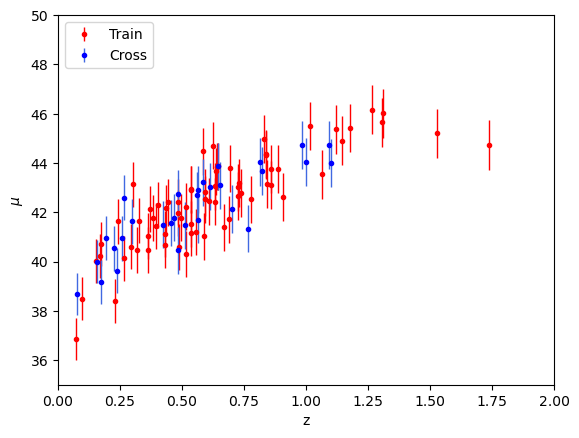

In [57]:
plt.errorbar(z_train, mu_train, dmu_train, fmt='.r', ecolor='red', lw=1, label='Train')
plt.errorbar(z_cross, mu_cross, dmu_cross, fmt='.b', ecolor='royalblue', lw=1, label='Cross')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='upper left')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

In [77]:
def rms_error(x_t, y_t, dy_t, x_c, y_c, degree):
    model = PolynomialRegression(degree)
    model.fit(x_t, y_t, dy_t)
    y_pred_t = model.predict(x_t)
    y_pred_c = model.predict(x_c)
    rms_train = np.sqrt(np.sum((y_t - y_pred_t) ** 2)/len(y_t))
    rms_cross = np.sqrt(np.sum((y_c - y_pred_c) ** 2)/len(y_c))
    return rms_train, rms_cross

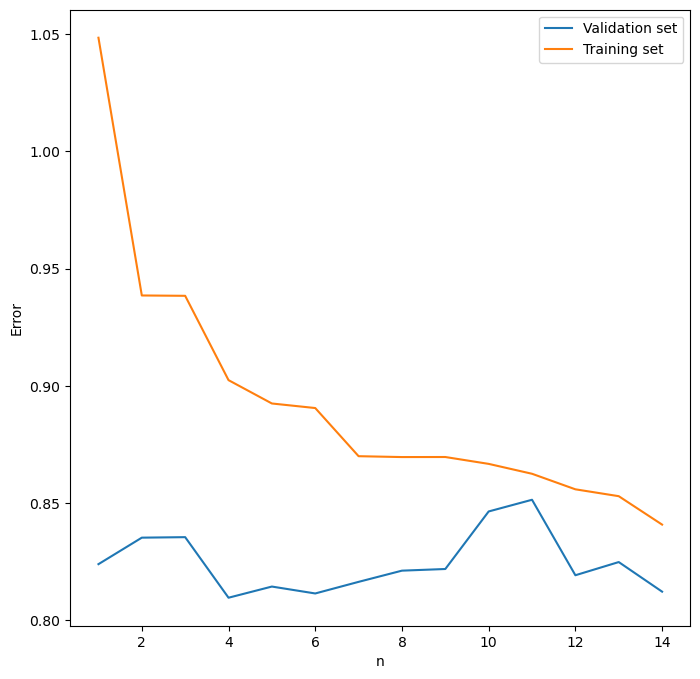

In [83]:
#d = np.arange(0, 21)
nrange = np.arange(1,15)

training_err = np.zeros(len(nrange))
crossval_err = np.zeros(len(nrange))

fig = plt.figure(figsize=(8, 8))
for n in nrange:
    training_err[n-1], crossval_err[n-1] = rms_error(z_train, mu_train, dmu_train, z_cross, mu_cross, n)

plt.plot(nrange, crossval_err, label='Validation set')
plt.plot(nrange, training_err, label='Training set')

plt.xlabel('n')
plt.ylabel('Error')
plt.legend();

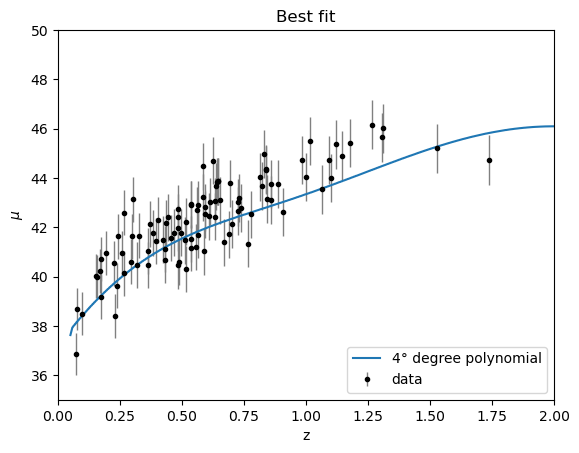

In [85]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(z, np.sort(poly(4)), label='4° degree polynomial')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.title('Best fit')
plt.xlim(0,2)
plt.ylim(35,50);